# Bathymetry

- Goal: quantify the extent to which bathymetry in CBay is related to the MHW Stats.
- Data source: bathymetry downloaded from [NOAA NCEI](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ngdc.mgg.dem:chesapeake_bay_M130_2017)

In [85]:
import os
from pathlib import Path

import rasterio
import xarray as xr
import rioxarray as rio
import scipy
import matplotlib.pyplot as plt

In [61]:
REPO_ROOT = Path('/Users/rwegener/repos/chesapeake_mhw')

## Converting the netcdf to tif

Followed [this great article](https://help.marine.copernicus.eu/en/articles/5029956-how-to-convert-netcdf-to-geotiff). Interesting to notice that the gdal version requires manually specified flags to work.

In [2]:
bath = xr.open_dataset('../../../data_archive/using/chesapeake_bay_M130_2017_bathymetry.nc')
z = bath['z']

In [3]:
z.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)
z.rio.write_crs("epsg:4326", inplace=True)

<xarray.DataArray 'z' (y: 31321, x: 19657)>
[615676897 values with dtype=float32]
Coordinates:
  * x             (x) float64 -77.43 -77.43 -77.43 ... -75.61 -75.61 -75.61
  * y             (y) float64 36.72 36.72 36.72 36.72 ... 39.62 39.62 39.62
    grid_mapping  int64 0
Attributes:
    long_name:     z
    actual_range:  [-54.29999924   0.        ]
    units:         meters

In [4]:
z.attrs = {}

In [5]:
# z.rio.to_raster('../data/chesapeake_bay_M130_2017_bathymetry.tif')

#### Checking Output

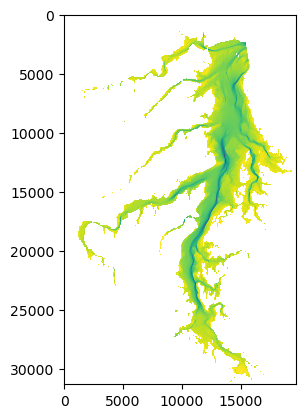

In [6]:
with rasterio.open('../../../data_archive/using/chesapeake_bay_M130_2017_bathymetry.tif') as src:
    z_raw = src.read()

plt.imshow(z_raw[0])

## Resampling to the geopolar grids

`rioxarray` has a `reproject_match()` method that turns out to be mighty helpful. [a mostly-code example here](https://corteva.github.io/rioxarray/stable/examples/reproject_match.html)

Works smoothy, but it looks like something underneath doesn't like the the georeferencing when I try to change the resampling method from `nearest` to `bilinear`. (maybe it's from mixing a .tif with a .nc?). Based on [this quick descriptive article from ESRI](https://support.esri.com/en/technical-article/000005606) it sounds like nearest makes the most sense for categorical data and I should actually try to use `bilinear`. **circle back**

- [resample_match docs](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.raster_array.RasterArray.reproject_match)
- seems like the error comes up whenever a Resample method is specified, even if `nearest` is specified

In [7]:
from rasterio.enums import Resampling

In [9]:
# ds = xr.open_dataset('../data/SST-geopolar-chesapeake/SST_geopolar_chesapeake.nc')
ds = xr.open_dataset('../../../data/01_raw/L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20030101_20231231.nc')
geopolar = ds.analysed_sst

In [11]:
geopolar.rio.write_crs("epsg:4326", inplace=True)

<xarray.DataArray 'analysed_sst' (time: 7663, lat: 65, lon: 40)>
[19923800 values with dtype=float32]
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01T12:00:00 ... 2023-12-31T12:...
  * lat          (lat) float32 36.78 36.83 36.88 36.92 ... 39.88 39.92 39.97
  * lon          (lon) float32 -77.47 -77.43 -77.38 ... -75.62 -75.57 -75.53
    spatial_ref  int64 0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -200
    valid_max:      4000
    reference:      Fieguth,P.W. et al. "Mapping Mediterranean altimeter data...
    source:         STAR-ACSPO_GAC, STAR-ACSPO_H-8, STAR-Geo_SST, UKMO-OSTIA
    comment:        Analysed SST for each ocean grid point

In [12]:
z_reproj = z.rio.reproject_match(geopolar)  # , method=Resampling.nearest)

In [13]:
z_reproj = z_reproj.rename({'x': 'longitude','y': 'latitude'})

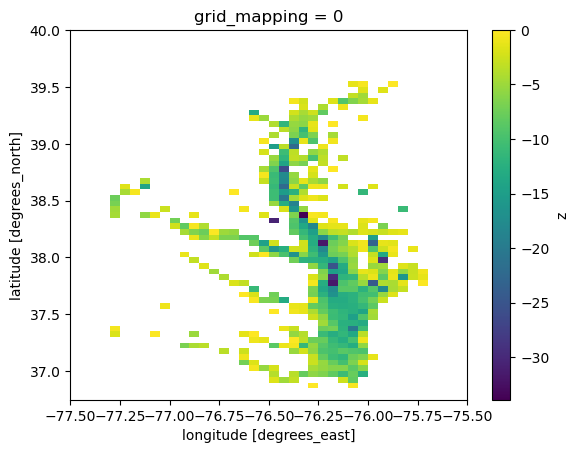

In [14]:
z_reproj.plot()

In [16]:
z_reproj.attrs = {'Source': 'chesapeake_bay_M130_2017_bathymetry.nc', 
                  'Note': 'resampled to the grid of the geopolar data'}

z_reproj.to_dataset(name='depth').to_netcdf('/Users/rwegener/repos/chesapeake_mhw/data_archive/using/chesapeake_bay_2017_bathymetry_resampled_geopolargrids.nc')


#### Alternate method for resampling: geowombat (not working)

- [docs page](https://pygis.io/docs/e_raster_resample.html)

Seemed hopefully but abandoned due to a mystery error. Says the CRS is not set. I tried specifying and resaving the netcdf, but now that I'm typing I wonder if because setting the crs happens in rio it doesn't get written unless I write to a raster...

That worked :tada: but it looks like the package versions may be out of sync? There is a rasterio error now that looks internal to the package 😢

In [19]:
geopolar.rio.to_raster('../data/SST-geopolar-chesapeake/SST_geopolar_chesapeake.tif')

AttributeError: module 'rasterio' has no attribute 'CRS'

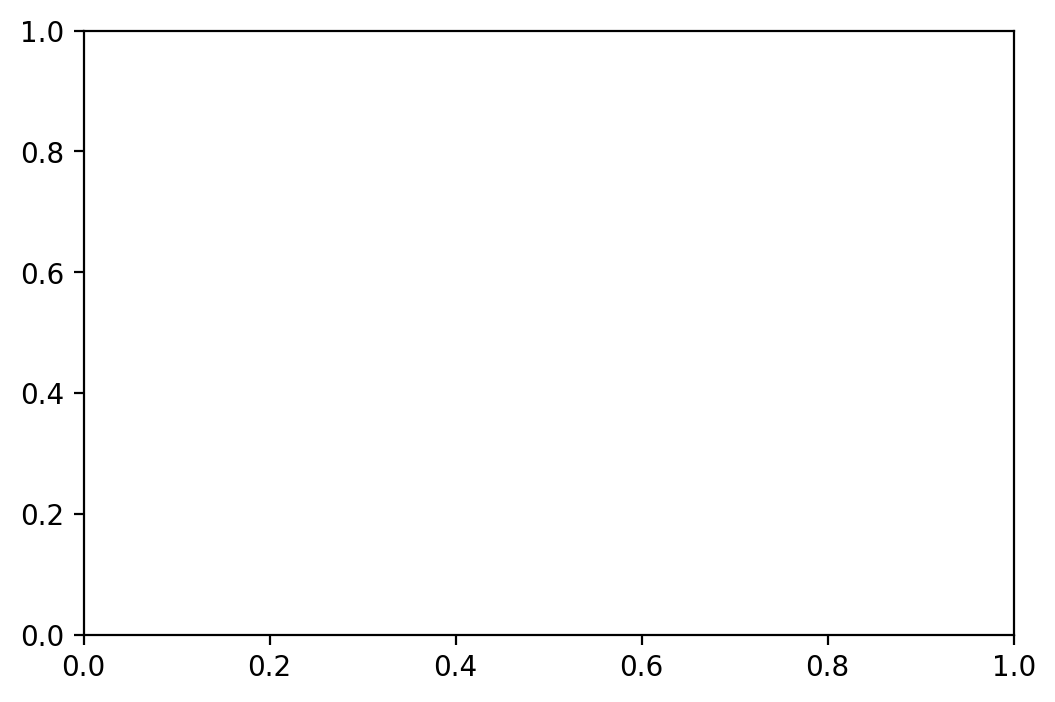

In [20]:
import geowombat as gw
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=200)


LS = "../data/SST-geopolar-chesapeake/SST_geopolar_chesapeake.tif"
precip = "../data/chesapeake_bay_M130_2017_bathymetry.tif"

with gw.config.update(ref_image=LS):
    with gw.open(precip, resampling="bilinear", nodata=-9999) as src:
        print(src)
        ax.imshow(src.data[0])
        
        # to write out simply:
        # src.gw.save(
        #     "../temp/precip_20200601_30m.tif",
        #     overwrite=True,
        # )

## Correlation Between Stats and Bathymetry

In [18]:
stats_dir = '../../../data/03_processed'

In [27]:
# open and extract dataarray
avg_dur = xr.open_dataset(os.path.join(stats_dir, 'mhw_average_characteristics.nc'))
avg_dur = avg_dur.avg_duration
# remove all the cells where we don't have bathymetry
avg_dur = avg_dur.where(~z_reproj.isnull())

In [65]:
# open and extract dataarray
avg_maxi = xr.open_dataset(os.path.join(stats_dir, 'mhw_average_characteristics.nc'))
avg_maxi = avg_maxi.avg_max_intensity
# remove all the cells where we don't have bathymetry
avg_maxi = avg_maxi.where(~z_reproj.isnull())

In [67]:
avg_dur = avg_dur.dropna(dim='latitude', how='all').dropna(dim='longitude', how='all')
avg_maxi = avg_maxi.dropna(dim='latitude', how='all').dropna(dim='longitude', how='all')
z_reproj = z_reproj.dropna(dim='latitude', how='all').dropna(dim='longitude', how='all')

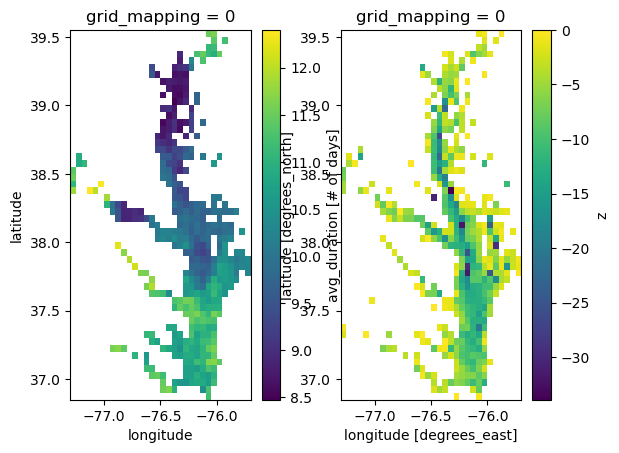

In [29]:
fig, axs = plt.subplots(1, 2)
avg_dur.plot(ax=axs[0])
z_reproj.plot(ax=axs[1])

In [68]:
avg_dur = avg_dur.assign_coords({"var": 'avg_dur'})
avg_maxi = avg_maxi.assign_coords({"var": 'avg_maxi'})
z_reproj = z_reproj.assign_coords({"var": 'z_reproj'})

In [72]:
z_reproj = z_reproj.drop('var')
avg_dur = avg_dur.drop('var')
avg_maxi = avg_maxi.drop('var')

In [73]:
avg_dur

<xarray.DataArray 'avg_duration' (latitude: 54, longitude: 32)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude      (latitude) float32 36.88 36.92 36.97 ... 39.42 39.47 39.53
  * longitude     (longitude) float32 -77.28 -77.22 -77.18 ... -75.78 -75.72
    grid_mapping  int64 0
Attributes:
    source:           NOAA Geopolar
    unit:             # of days
    description:      The 'duration' statistic reported from EJO's MHW code f...
    processing_date:  2025-01-18

In [74]:
avg_maxi

<xarray.DataArray 'avg_max_intensity' (latitude: 54, longitude: 32)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude      (latitude) float32 36.88 36.92 36.97 ... 39.42 39.47 39.53
  * longitude     (longitude) float32 -77.28 -77.22 -77.18 ... -75.78 -75.72
    grid_mapping  int64 0
Attributes:
    source:           NOAA Geopolar
    unit:             deg C
    description:      returns the average value for the maximum intensity, `i...
    processing_date:  2025-01-18

In [75]:
combined_ds = xr.merge([avg_dur, avg_maxi, z_reproj])

In [47]:
x = combined_ds.avg_duration.values.flatten()
y = combined_ds.z.values.flatten()

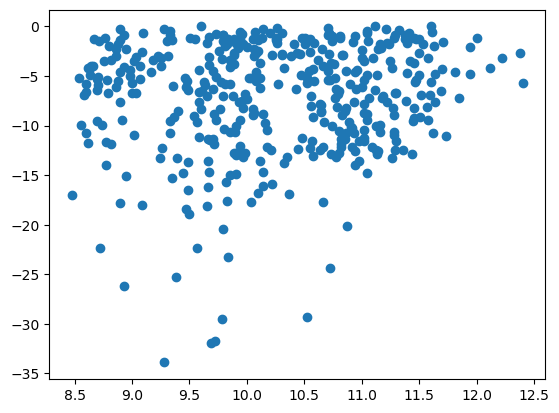

In [50]:
fig, ax = plt.subplots(1, 1)

ax.scatter(x, y)

ax.set_xlabel('Average duration (days)')

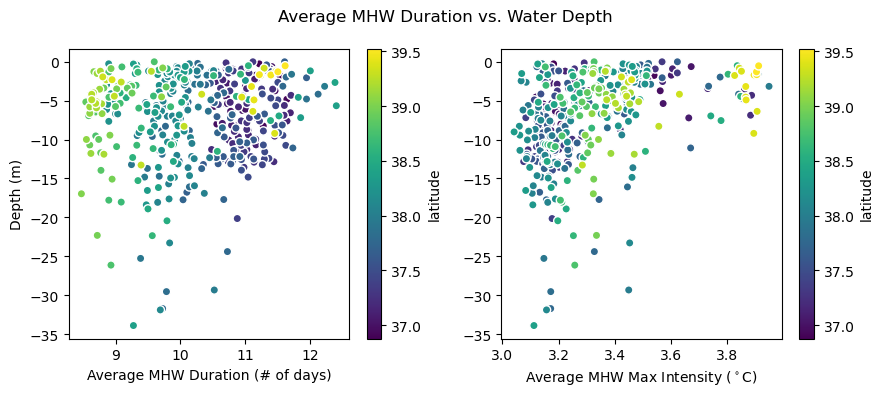

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(9, 4)

# plt.scatter(
xr.plot.scatter(combined_ds, x='avg_duration', y='z', ax=ax1, hue='latitude')
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel('Average MHW Duration (# of days)')

xr.plot.scatter(combined_ds, x='avg_max_intensity', y='z', ax=ax2, hue='latitude')
ax2.set_ylabel('')
ax2.set_xlabel('Average MHW Max Intensity ($^\circ$C)')

for ax in (ax1, ax2):
    ax.set_title('')

fig.suptitle('Average MHW Duration vs. Water Depth')

plt.tight_layout()

plt.savefig(REPO_ROOT / 'figures/04_supplementalmaterial' / 'bathymetry.png')

Duration vs. Depth

In [91]:
import pandas as pd

In [93]:
dur_df = pd.DataFrame({
    'duration': combined_ds.avg_duration.values.flatten(), 
    # 'intensity': combined_ds.avg_max_intensity.values.flatten(), 
    'depth': combined_ds.z.values.flatten()
})

In [96]:
dur_df = dur_df[(~dur_df.duration.isnull()) & (~dur_df.depth.isnull())]

In [ ]:
x = combined_ds.avg_duration.values.flatten()
y = combined_ds.z.values.flatten()

In [97]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dur_df.duration, dur_df.depth)
# filter out points that aren't significant
if p_value > 0.05:
    print('not significant')


In [102]:
r_value**2

0.011500267779326218

Conclusions:
- no clear relationship. not that surprised just based on eyeing up the two rasters
- it makes some sense to me that the over all depth isn't what matters but that it would really be the mixed layer. I took another stab at finding some mixed layer info. I think its possible some is hidden in the operational now/forecasts of the bay, but even if I were to get those it I wouldn't be able to do more than check a huntch (I doubt I'd be able to get data, form a real climatology, and analyze it be the 8th)
- Next: transitioning to buoy data for riverine validation

In [37]:
# open and extract dataarray
avg_int = xr.open_dataset(os.path.join(stats_dir, 'average_max_intensity_CBay_geopolar.nc'))
avg_int = avg_int.avg_max_intensity
# remove all the cells where we don't have bathymetry
avg_int = avg_int.where(~z_reproj.isnull())

In [38]:
avg_int = avg_int.dropna(dim='latitude', how='all').dropna(dim='longitude', how='all')

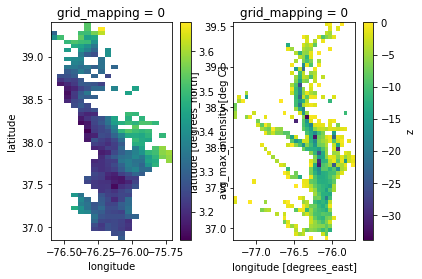

In [39]:
fig, axs = plt.subplots(1, 2)
avg_int.plot(ax=axs[0])
z_reproj.plot(ax=axs[1])

In [40]:
avg_int = avg_int.assign_coords({"var": 'avg_dur'})

In [41]:
combined_ds = xr.merge([avg_int, z_reproj])

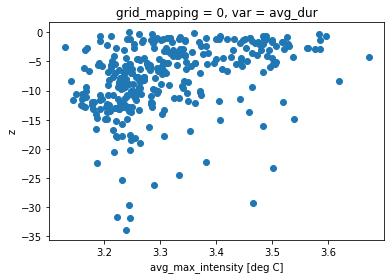

In [42]:
xr.plot.scatter(combined_ds, x='avg_max_intensity', y='z')